Locating Files And Mounting Video Files

In [ ]:
import glob
import numpy as np
import cv2
import random
from google.colab import drive
drive.mount('/content/drive')
video_files = glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/FF_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/DFDC_REAL_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/DFDC_FAKE_Face_only_data/*.mp4')
if not video_files:
    print("No videos found! Check the folder paths.")
else:
    print(f"Found {len(video_files)} videos.")
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not cap.isOpened():
        print(f"Could not open video: {video_file}")
        continue
    if total_frames < 100:
        print(f"Skipping {video_file} (Only {total_frames} frames)")
        continue
    frame_count.append(total_frames)
print("Frames per video:", frame_count)
print("Total number of valid videos:", len(frame_count))
print("Average frames per video:", np.mean(frame_count) if frame_count else 0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1168 videos.
Frames per video: [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148

Installing Dependencies


In [4]:
!pip install face_recognition
!pip uninstall numpy
!pip install numpy==1.24.3

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 93.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requir

Loading Video Name And Labels From CSV

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

Fake And Real Video Counts

In [ ]:
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

Loading Labels And Video Into Data Loader


train :  934
test :  234
TRAIN:  Real: 475  Fake: 459


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TEST:  Real: 113  Fake: 121


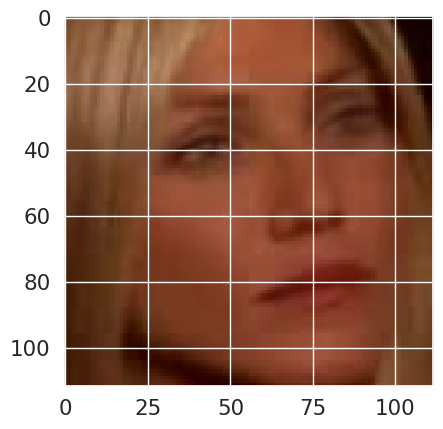

In [ ]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split
header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
train_videos = video_files[:int(0.8*len(video_files))]
test_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(test_videos))
print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(test_videos)[0]," Fake:",number_of_real_and_fake_videos(test_videos)[1])
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
val_data = video_dataset(test_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
test_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

Feature Visualization Model

In [ ]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

Model Instantiation

In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Training Class Definition

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Training Loss: %f, Training Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Validation Loss: %f, Validation Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

Confusion Matrix Printing

In [ ]:
import seaborn as sn
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 16})
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Testing Accuracy of the trained model = ",calculated_acc*100)

Plotting Accuracy And Loss

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

Model Training With 20 Epochs

[Epoch 1/20] [Batch 233 / 234] [Training Loss: 0.439591, Training Acc: 85.33%]Testing
[Batch 58 / 59]  [Validation Loss: 0.354534, Validation Acc: 87.18%]
Accuracy 87.17948717948718
[Epoch 2/20] [Batch 233 / 234] [Training Loss: 0.413851, Training Acc: 86.08%]Testing
[Batch 58 / 59]  [Validation Loss: 0.376351, Validation Acc: 83.76%]
Accuracy 83.76068376068376
[Epoch 3/20] [Batch 233 / 234] [Training Loss: 0.374785, Training Acc: 86.72%]Testing
[Batch 58 / 59]  [Validation Loss: 0.345046, Validation Acc: 85.04%]
Accuracy 85.04273504273505
[Epoch 4/20] [Batch 233 / 234] [Training Loss: 0.385026, Training Acc: 88.76%]Testing
[Batch 58 / 59]  [Validation Loss: 0.336929, Validation Acc: 84.19%]
Accuracy 84.1880341880342
[Epoch 5/20] [Batch 233 / 234] [Training Loss: 0.352834, Training Acc: 89.29%]Testing
[Batch 58 / 59]  [Validation Loss: 0.368218, Validation Acc: 84.62%]
Accuracy 84.61538461538461
[Epoch 6/20] [Batch 233 / 234] [Training Loss: 0.347634, Training Acc: 90.04%]Testing
[Batc

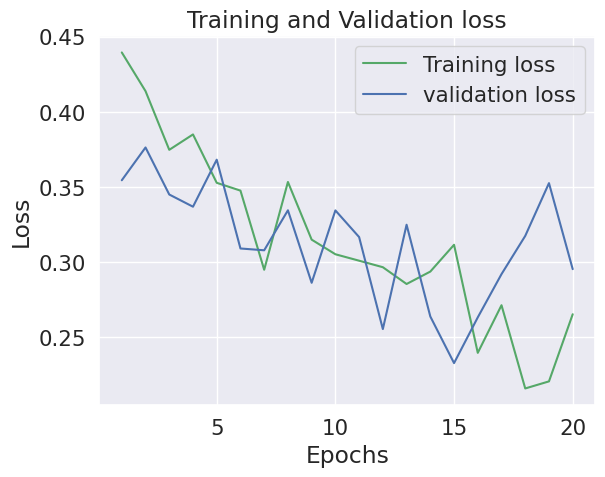

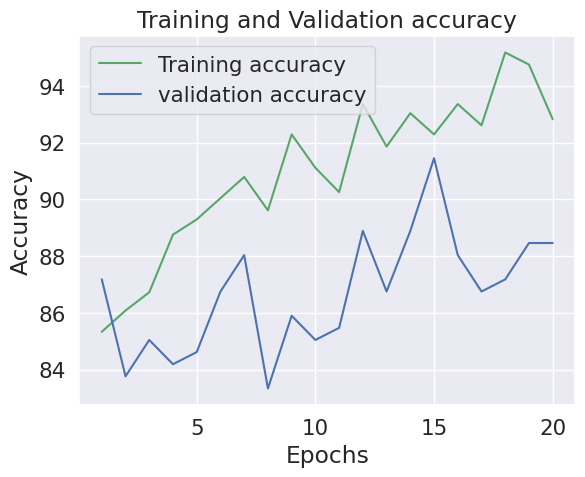

[[112   9]
 [ 18  95]]
True positive =  112
False positive =  9
False negative =  18
True negative =  95




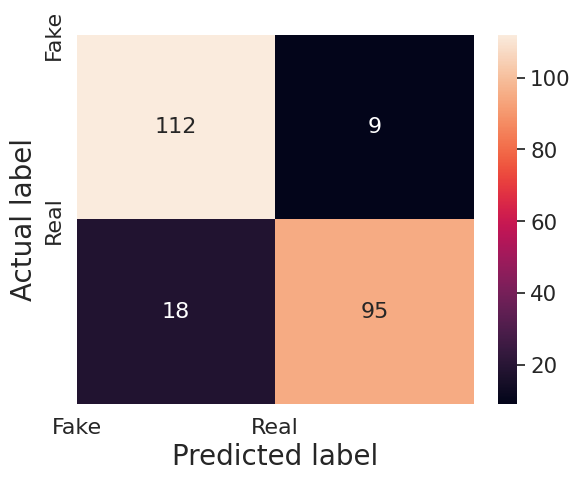

Testing Accuracy of the trained model =  88.46153846153845


In [ ]:
from sklearn.metrics import confusion_matrix
lr = 1e-5
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,test_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

Installing Correct Dependency Version

In [1]:
!pip install face-recognition==1.3.0
!pip install face-recognition-models==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=ba12fd23ba45c7d224fe49b1020ae3649967125bd0e13d6b22a70b80f168d275
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


Predictions

In [6]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import cv2
import os
import time
import face_recognition
from PIL import Image
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(x_lstm[:, -1, :]))
class VideoDataset:
    def __init__(self, video_path, sequence_length=60, transform=None):
        self.video_path = video_path
        self.transform = transform
        self.sequence_length = sequence_length
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        frames = []
        for i, frame in enumerate(self._extract_frames()):
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                faces = face_recognition.face_locations(rgb_frame)
                try:
                    top, right, bottom, left = faces[0]
                    frame = rgb_frame[top:bottom, left:right]
                except:
                    frame = rgb_frame
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
                if len(frames) == self.sequence_length:
                    break
        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))
        return torch.stack(frames).unsqueeze(0)
    def _extract_frames(self):
        vid = cv2.VideoCapture(self.video_path)
        while True:
            success, frame = vid.read()
            if success:
                yield frame
            else:
                break
def predict(model, video_path, sequence_length=60):
    im_size = 112
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    dataset = VideoDataset(video_path, sequence_length, transform)
    video_tensor = dataset[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    video_tensor = video_tensor.to(device)
    with torch.no_grad():
        _, logits = model(video_tensor)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        confidence, prediction = torch.max(probabilities, 1)
    return "REAL" if prediction.item() == 1 else "FAKE", confidence.item() * 100
def main():
    video_path = r"/content/videoplayback.mp4"
    model_path = r"/content/final_model.pt"
    sequence_length = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    start_time = time.time()
    print("Starting prediction...")
    result, confidence = predict(model, video_path, sequence_length)
    print(f"Prediction: {result} (Confidence: {confidence:.2f}%)")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
if __name__ == "__main__":
    main()

Starting prediction...
Prediction: FAKE (Confidence: 100.00%)
Time taken: 4.96 seconds
